In [21]:
import pandas as pd
import os
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

plt.rcParams.update({'font.size': 22, 'grid.linestyle': '-', 'grid.color': 'gray' })


In [22]:
dataset_raw_file = "../data/output/dataset_raw.tsv"
datase_file = "../data/output/dataset.tsv"
references_dir = "../data/output/references"
ncbi_tax_file = "../data/new_taxdump/rankedlineage.dmp"

# Output
fig_dir = "../data/output/references_stat"

In [23]:
tuples = []
for reference_file in os.listdir(references_dir):
    with open("{}/{}".format(references_dir, reference_file)) as f:
        data = {}
        reference_name = reference_file.split(".")[0]
        group = None
        for k in ['linker', 'binding', 'disorder']:  # order matters
            if k in reference_name:
                group = k
                break
        for line in f:
            if line:
                if line[0] == ">":
                    name = line.strip()[1:]
                    data.setdefault(name, [])
                else:
                    data[name].append(list(line.strip()))
        for name in data:
            for i, (aa, val) in enumerate(zip(*data[name])):
                tuples.append((group, reference_name, name, i + 1, aa, val))
df = pd.DataFrame(tuples, columns=['group', 'reference', 'disprot_id', 'pos', 'aa', 'value'])
df.set_index(['group', 'reference', 'disprot_id', 'pos', 'aa'], inplace=True)
df

value
group    reference       disprot_id pos aa      
linker   linker_disorder DP02418    1   M      -
                                    2   A      -
                                    3   S      -
                                    4   P      -
                                    5   P      -
...                                          ...
disorder disorder_nox    DP03744    174 R      1
                                    175 T      1
                                    176 N      1
                                    177 R      1
                                    178 I      1

[1241281 rows x 1 columns]

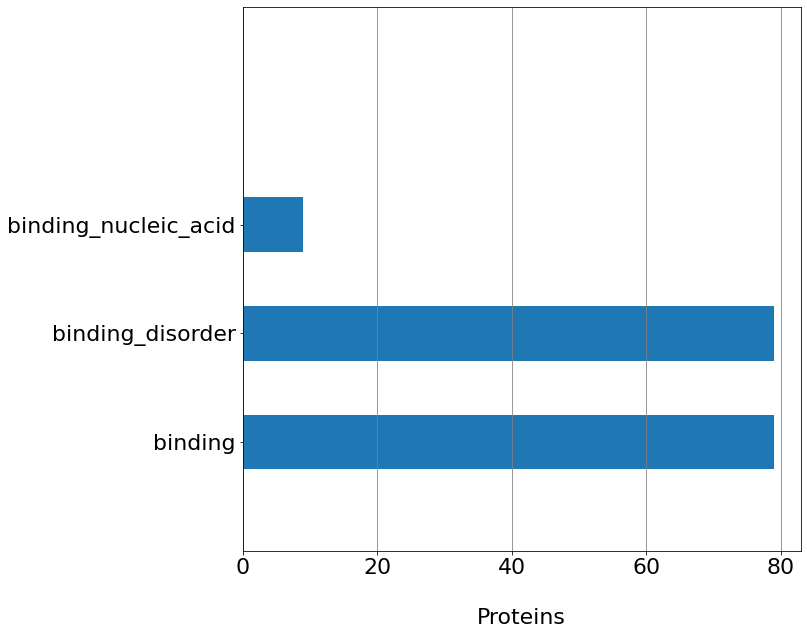

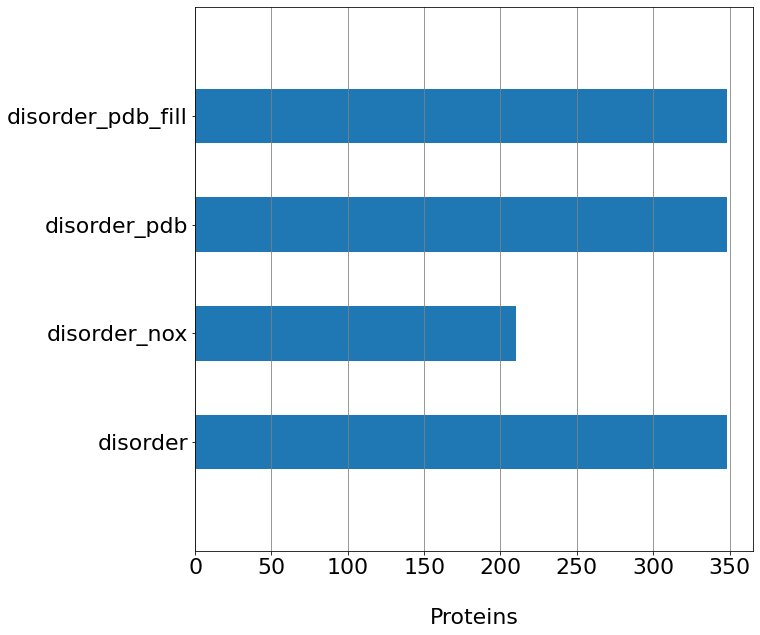

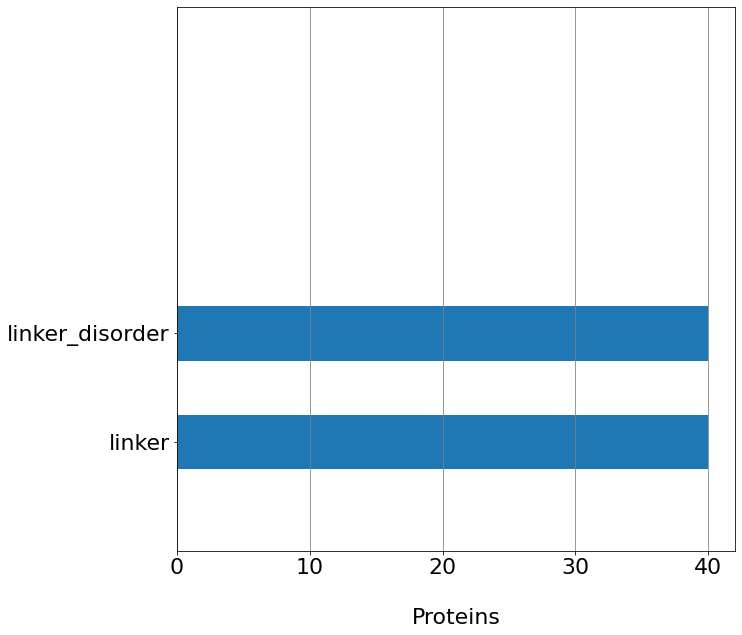

In [24]:
for group, df_g in df.groupby(level='group'):
    df2 = df_g.reset_index(level='disprot_id').groupby(['reference'])['disprot_id'].nunique().reset_index().set_index('reference')
    # print(df2)

    fig, ax = plt.subplots(figsize=(10, 10))
    df2.plot(kind='barh', width=0.5, ax=ax)
    ax.xaxis.grid()
    ax.set_ybound(-1, 4)
    ax.get_legend().remove()
    ax.set_xlabel('Proteins', labelpad=30)

    fig.gca().set_ylabel("")
    fig.savefig("{}/stat_proteins_{}.png".format(fig_dir, group), dpi=300, bbox_inches='tight')

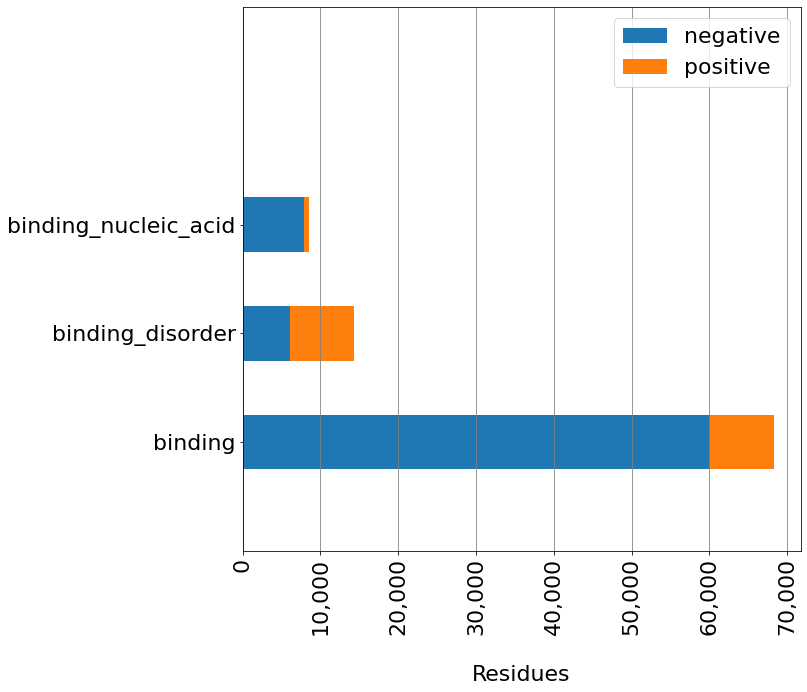

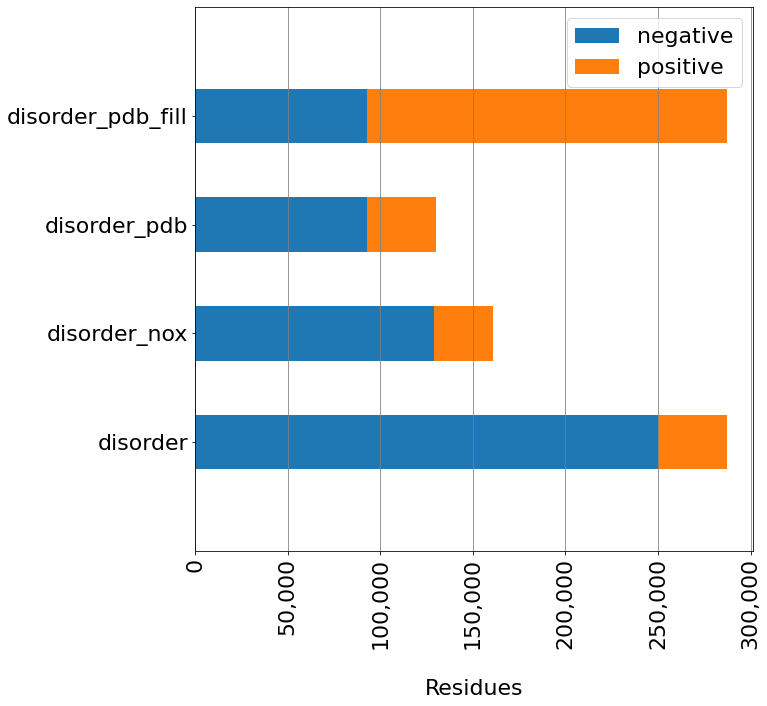

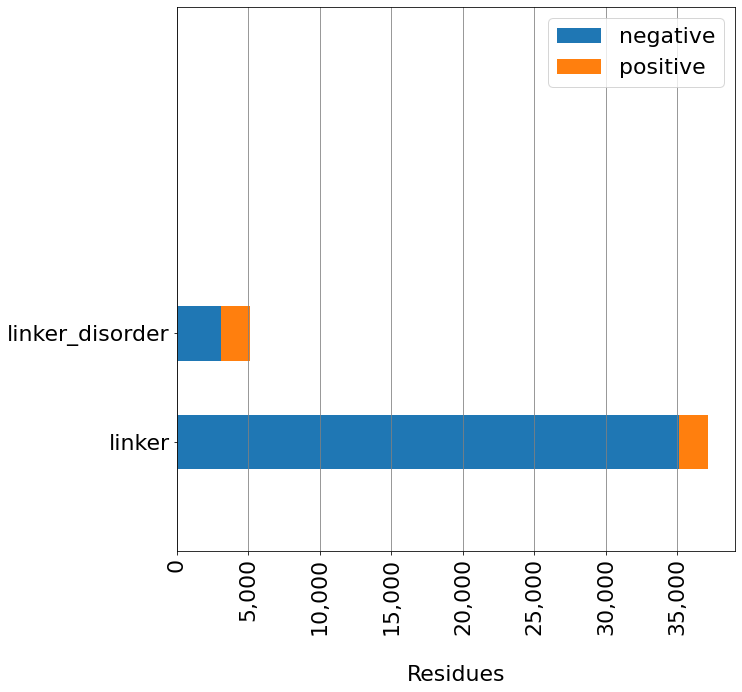

In [25]:
# TODO print the ratio (%) on top of the bars
for group, df_g in df.groupby(level='group'):
    df2 = df_g.groupby(['reference'])['value'].value_counts().unstack('value').fillna(0).sort_values(by=['reference'], ascending=[True]).drop(columns=['-'])
    # print(df2)

    fig, ax = plt.subplots(figsize=(10, 10))
    df2.plot(kind='barh', stacked=True, ax=ax)
    ax.xaxis.grid()
    ax.set_ybound(-1, 4)
    ax.set_xlabel('Residues', labelpad=30)
    ax.xaxis.set_major_formatter( matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
    ax.tick_params(axis='x', labelrotation=90)

    ax.legend(['negative', 'positive'])

    fig.gca().set_ylabel("")
    fig.savefig("{}/stat_residues_{}.png".format(fig_dir, group), dpi=300, bbox_inches='tight')

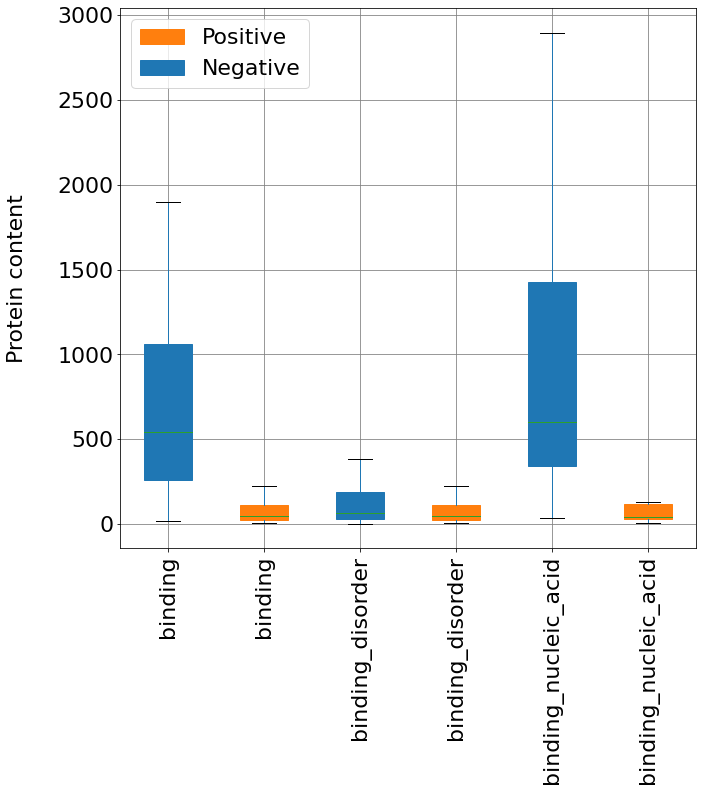

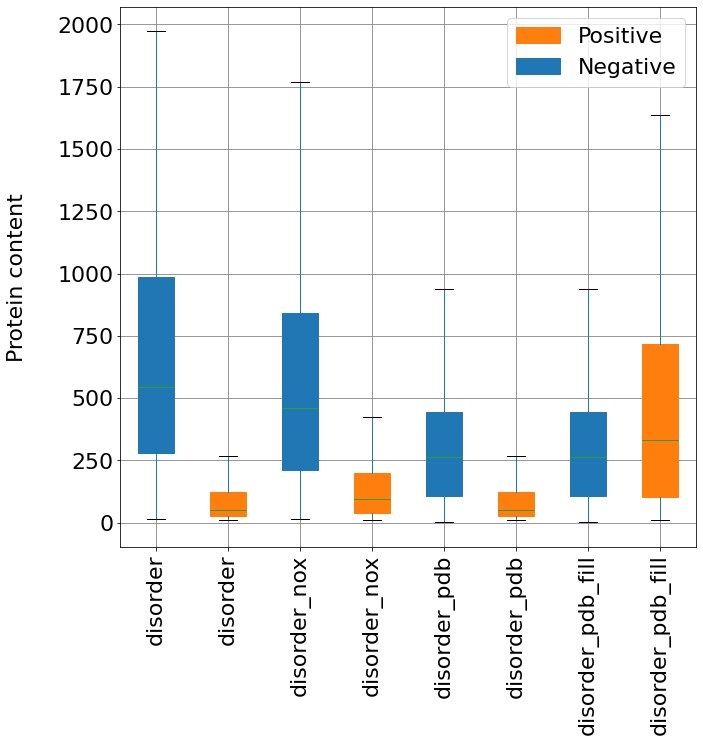

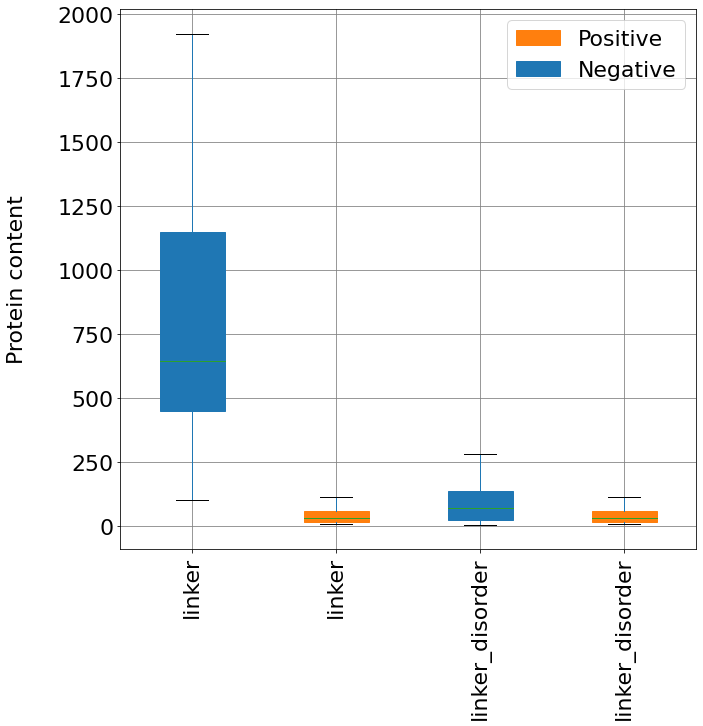

In [26]:
# Content at the protein level
for group, df_g in df.reset_index().groupby('group'):
    df_len = df_g.groupby(['disprot_id', 'reference', 'value']).agg({'pos': 'count'}).droplevel('disprot_id').reset_index()
    df_len = df_len.loc[df_len['value'] != '-']
    # print(df_len)

    fig, ax = plt.subplots(figsize=(10, 10))
    bp = df_len.boxplot(by=['reference', 'value'], ax=ax, showfliers=False, return_type='dict', patch_artist=True)
    ax.tick_params(axis='x', labelrotation=90)
    # fill with colors
    colors = {'0': '#1f77b4', '1': '#ff7f0e'}
    for patch, (label, df_g) in zip(bp['pos']['boxes'], df_len.groupby(['reference', 'value'])):
        patch.set_color(colors[label[1]])

    ax.set_ylabel('Protein content', labelpad=30)

    positive = mpatches.Patch(label='Positive', color=colors['1'])
    negative = mpatches.Patch(label='Negative', color=colors['0'])
    ax.legend(handles=[positive, negative])

    labels = [item.get_text()[1:-1].split(",")[0] for item in ax.get_xticklabels()]
    ax.set_xticklabels(labels)


    plt.suptitle("")
    plt.title('')
    fig.gca().set_xlabel("")
    fig.savefig("{}/stat_content_{}.png".format(fig_dir, group), dpi=300, bbox_inches='tight')
    # break

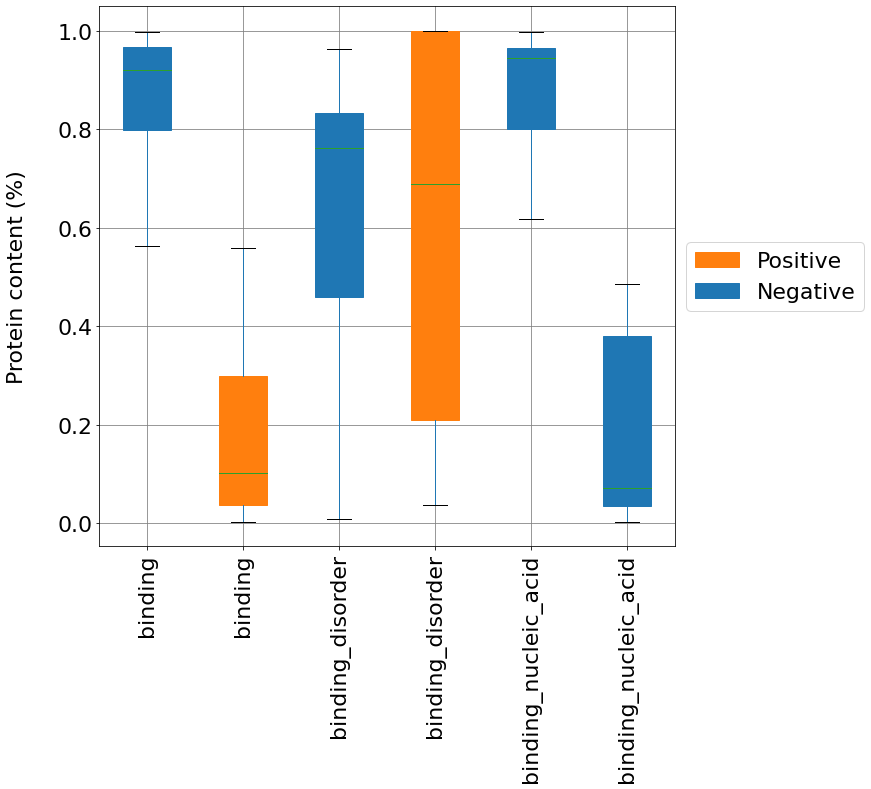

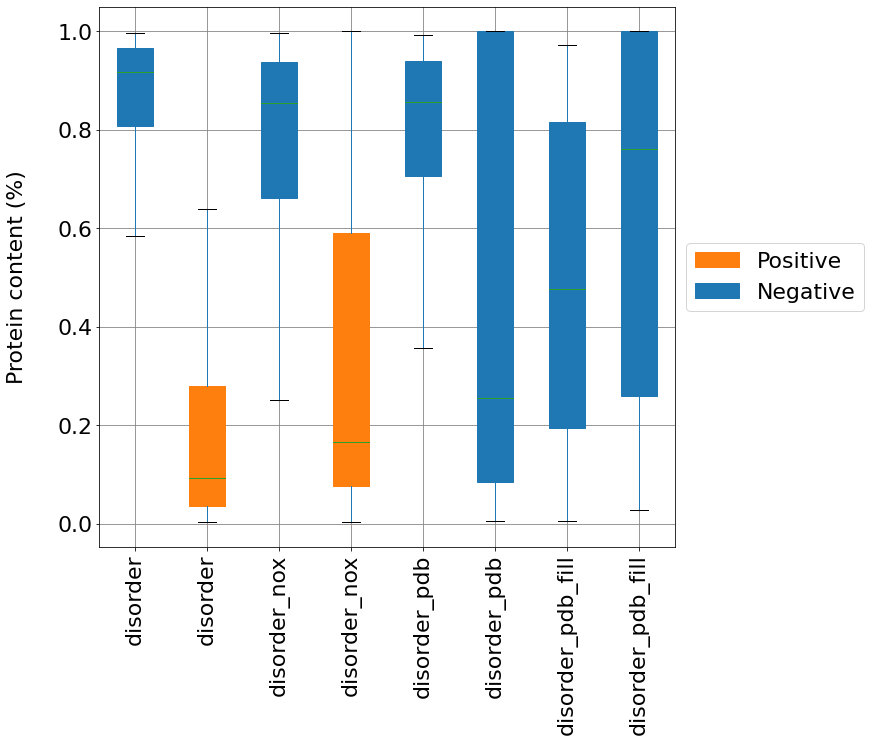

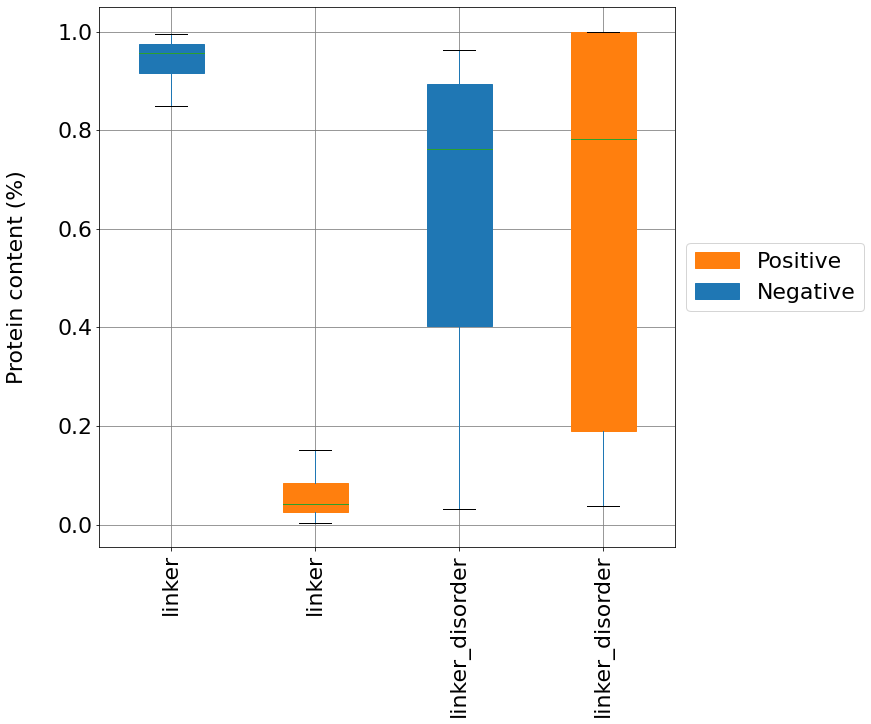

In [27]:
# Content at the protein level
for group, df_g in df.reset_index().groupby('group'):
    df_ = df_g.groupby(['disprot_id', 'reference', 'value']).agg({'pos': 'count'}).reset_index()
    df_ = df_.loc[df_['value'] != '-']#.droplevel('disprot_id').reset_index()#.pivot(index='reference', columns='value', values='pos')
    df_tot = df_.groupby(['disprot_id', 'reference']).agg({'pos': 'sum'})
    df_ = pd.merge(df_, df_tot, on=['disprot_id', 'reference'])
    df_['fraction'] = df_['pos_x'] / df_['pos_y']
    # print(df_)

    fig, ax = plt.subplots(figsize=(10, 10))
    bp = df_.loc[:, ['reference', 'value', 'fraction']].boxplot(by=['reference', 'value'], ax=ax, showfliers=False, return_type='dict', patch_artist=True)
    ax.tick_params(axis='x', labelrotation=90)
    # fill with colors
    colors = {'0': '#1f77b4', '1': '#ff7f0e'}
    for patch, (label, df_g) in zip(bp['fraction']['boxes'], df_len.groupby(['reference', 'value'])):
        patch.set_color(colors[label[1]])

    ax.set_ylabel('Protein content (%)', labelpad=30)

    positive = mpatches.Patch(label='Positive', color=colors['1'])
    negative = mpatches.Patch(label='Negative', color=colors['0'])
    ax.legend(handles=[positive, negative], loc='center left', bbox_to_anchor=(1.0, 0.5))

    labels = [item.get_text()[1:-1].split(",")[0] for item in ax.get_xticklabels()]
    ax.set_xticklabels(labels)

    plt.suptitle("")
    plt.title('')
    fig.gca().set_xlabel("")
    fig.savefig("{}/stat_content_normalized_{}.png".format(fig_dir, group), dpi=300, bbox_inches='tight')

    # break

In [28]:
df = pd.read_csv(dataset_raw_file, sep="\t")
df.columns

Index(['region_id', 'unpublished', 'ec_ontology', 'end', 'term_id', 'start',
       'version', 'statement', 'term_name', 'ec_name', 'curator_orcid',
       'released', 'term_ontology', 'curator_name', 'reference_id', 'date',
       'reference_source', 'term_namespace', 'ec_id', 'curator_id',
       'reference_html', 'ec_go', 'disprot_namespace', 'validated.curator_id',
       'validated.timestamp', 'validated.curator_name', 'term_not_annotate',
       'term_is_obsolete', 'term_comment', 'term_def', 'term_is_binding',
       'interaction_partner', 'cross_refs', 'confidence', 'sample',
       'term_xref', 'construct_alterations', 'sequence_construct',
       'term_go_domain', 'states_connection', 'conditions',
       'annotation_extensions', 'disprot_id', 'acc', 'ncbi_taxon_id',
       'organism', 'sequence', 'challenge'],
      dtype='object')

In [29]:
def expand_region(df_:pd.DataFrame, start_col:str='start', end_col:str='end', res_col:str='reg_position') -> pd.DataFrame:
    df_[res_col] = list(range(int(df_[start_col]), int(df_[end_col]) + 1, 1))
    return df_

In [30]:
df_pos = df.apply(expand_region, axis=1).explode("reg_position")
df_pos

,region_id,unpublished,ec_ontology,end,term_id,start,version,statement,term_name,ec_name,...,states_connection,conditions,annotation_extensions,disprot_id,acc,ncbi_taxon_id,organism,sequence,challenge,reg_position
0,DP02342r003,True,ECO,227,IDPO:00078,1,3,[{'text': 'CD spectra of Nm and Ng showed an i...,pre-molten globule,far-UV circular dichroism evidence used in man...,...,NaN,NaN,NaN,DP02342,P06837,10090,Mus musculus,MLCCMRRTKQVEKNDEDQKIEQDGVKPEDKAHKAATKIQASFRGHI...,disorder,1
0,DP02342r003,True,ECO,227,IDPO:00078,1,3,[{'text': 'CD spectra of Nm and Ng showed an i...,pre-molten globule,far-UV circular dichroism evidence used in man...,...,NaN,NaN,NaN,DP02342,P06837,10090,Mus musculus,MLCCMRRTKQVEKNDEDQKIEQDGVKPEDKAHKAATKIQASFRGHI...,disorder,2
0,DP02342r003,True,ECO,227,IDPO:00078,1,3,[{'text': 'CD spectra of Nm and Ng showed an i...,pre-molten globule,far-UV circular dichroism evidence used in man...,...,NaN,NaN,NaN,DP02342,P06837,10090,Mus musculus,MLCCMRRTKQVEKNDEDQKIEQDGVKPEDKAHKAATKIQASFRGHI...,disorder,3
0,DP02342r003,True,ECO,227,IDPO:00078,1,3,[{'text': 'CD spectra of Nm and Ng showed an i...,pre-molten globule,far-UV circular dichroism evidence used in man...,...,NaN,NaN,NaN,DP02342,P06837,10090,Mus musculus,MLCCMRRTKQVEKNDEDQKIEQDGVKPEDKAHKAATKIQASFRGHI...,disorder,4
0,DP02342r003,True,ECO,227,IDPO:00078,1,3,[{'text': 'CD spectra of Nm and Ng showed an i...,pre-molten globule,far-UV circular dichroism evidence used in man...,...,NaN,NaN,NaN,DP02342,P06837,10090,Mus musculus,MLCCMRRTKQVEKNDEDQKIEQDGVKPEDKAHKAATKIQASFRGHI...,disorder,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1106,DP03739r012,True,ECO,417,GO:0005516,390,0,"[{'text': 'However, on addition of Calmodulin,...",calmodulin binding,nuclear magnetic resonance spectroscopy eviden...,...,NaN,NaN,NaN,DP03739,P24588,9606,Homo sapiens,METTISEIHVENKDEKRSAEGSPGAERQKEKASMLCFKRRKKAAKA...,binding protein,413
1106,DP03739r012,True,ECO,417,GO:0005516,390,0,"[{'text': 'However, on addition of Calmodulin,...",calmodulin binding,nuclear magnetic resonance spectroscopy eviden...,...,NaN,NaN,NaN,DP03739,P24588,9606,Homo sapiens,METTISEIHVENKDEKRSAEGSPGAERQKEKASMLCFKRRKKAAKA...,binding protein,414
1106,DP03739r012,True,ECO,417,GO:0005516,390,0,"[{'text': 'However, on addition of Calmodulin,...",calmodulin binding,nuclear magnetic resonance spectroscopy eviden...,...,NaN,NaN,NaN,DP03739,P24588,9606,Homo sapiens,METTISEIHVENKDEKRSAEGSPGAERQKEKASMLCFKRRKKAAKA...,binding protein,415
1106,DP03739r012,True,ECO,417,GO:0005516,390,0,"[{'text': 'However, on addition of Calmodulin,...",calmodulin binding,nuclear magnetic resonance spectroscopy eviden...,...,NaN,NaN,NaN,DP03739,P24588,9606,Homo sapiens,METTISEIHVENKDEKRSAEGSPGAERQKEKASMLCFKRRKKAAKA...,binding protein,416


In [31]:
df_ec = pd.merge(df_pos.groupby(['challenge', 'ec_name'], as_index=False)['reg_position'].nunique(), df_pos.groupby(['challenge'], as_index=False)['reg_position'].nunique(), on='challenge').rename({'reg_position_x': 'count', 'reg_position_y': 'total'}, axis=1).sort_values(by=['challenge', 'count'], ascending=[True, True])
df_ec['fraction'] = df_ec['count'] / df_ec['total']
df_ec

,challenge,ec_name,count,total,fraction
13,binding,enzymatic activity assay evidence used in manu...,9,2037,0.004418
24,binding,luciferase reporter gene assay evidence used i...,11,2037,0.005400
33,binding,qualitative western immunoblotting evidence us...,11,2037,0.005400
32,binding,protein kinase assay evidence used in manual a...,12,2037,0.005891
11,binding,deletion mutation phenotypic evidence used in ...,20,2037,0.009818
...,...,...,...,...,...
138,transition,nuclear magnetic resonance spectroscopy eviden...,415,964,0.430498
129,transition,analytical ultracentrifugation evidence used i...,497,964,0.515560
130,transition,chromatography evidence used in manual assertion,497,964,0.515560
141,transition,x-ray crystallography evidence used in manual ...,529,964,0.548755


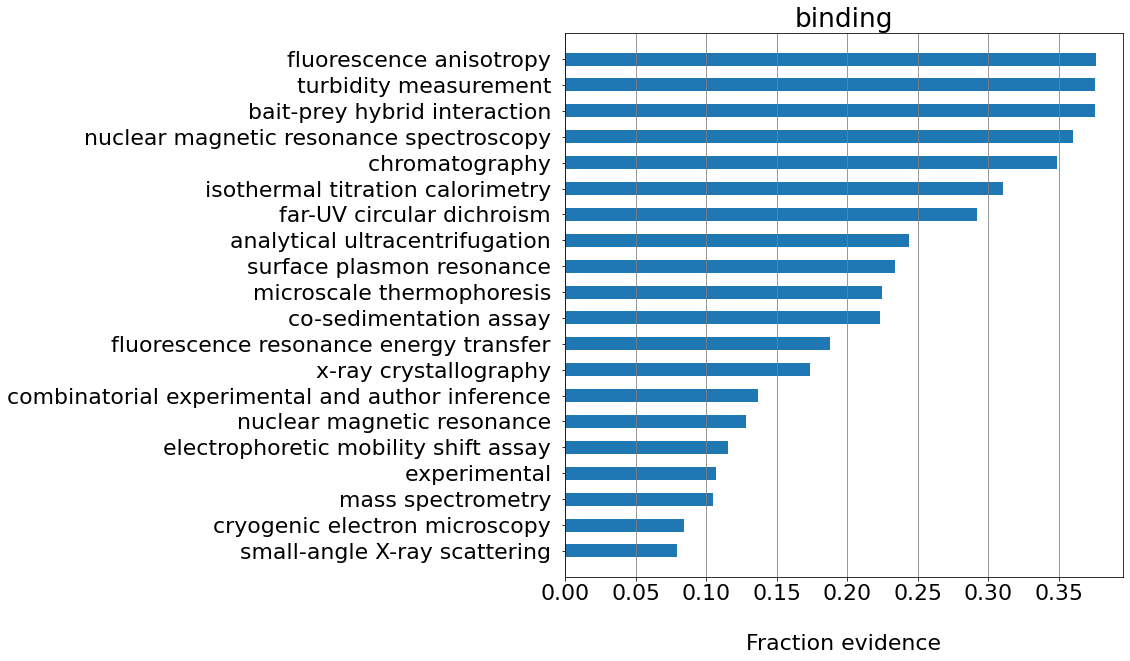

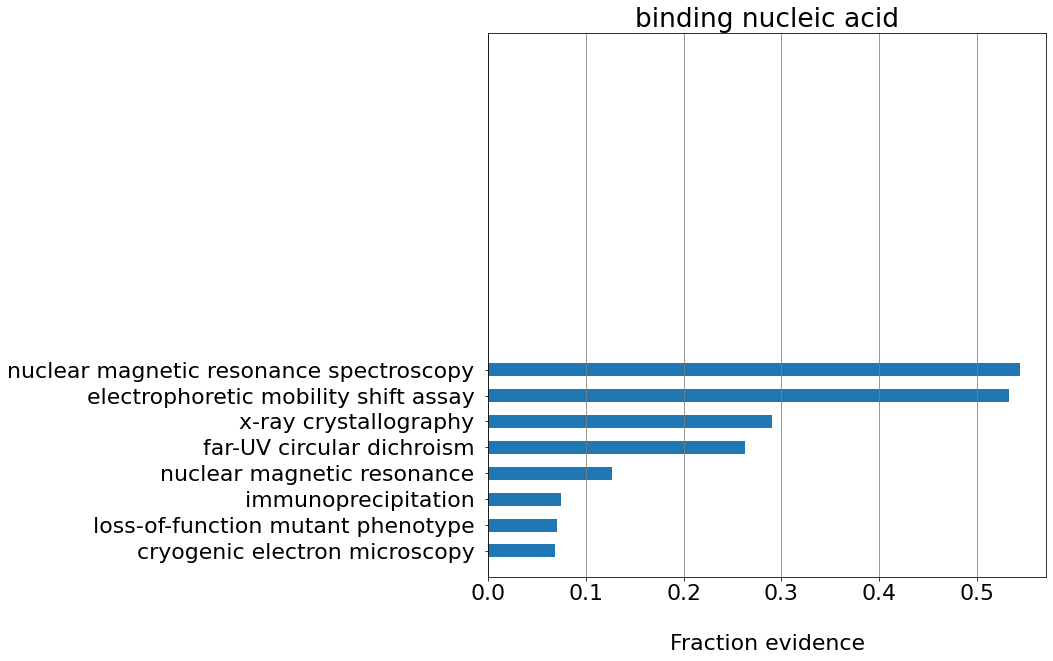

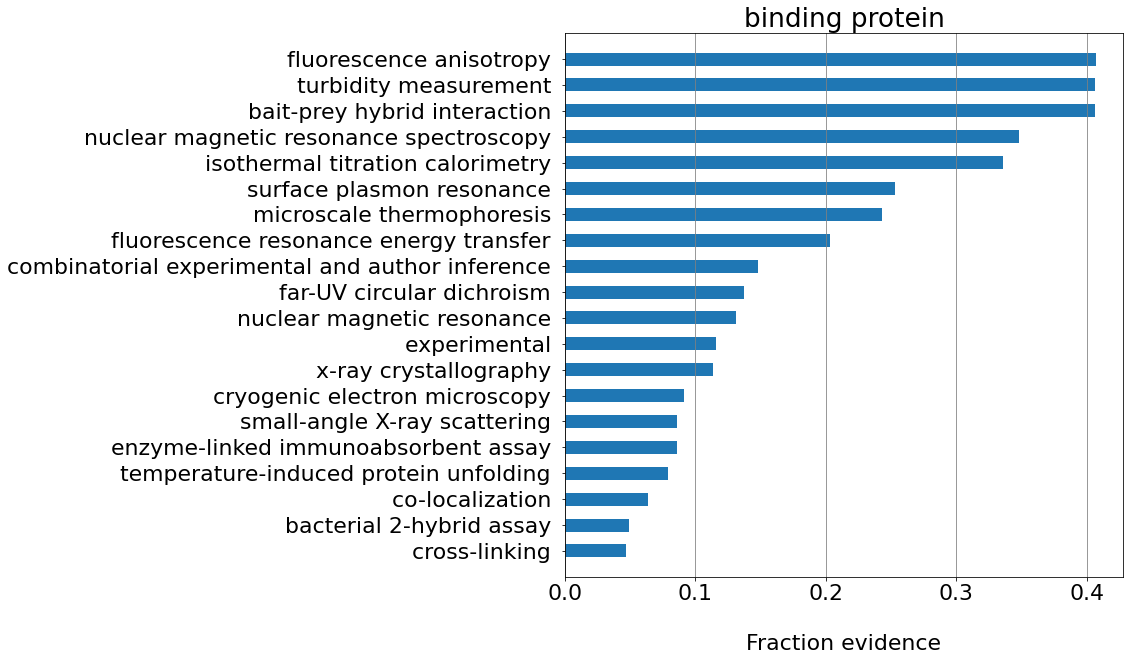

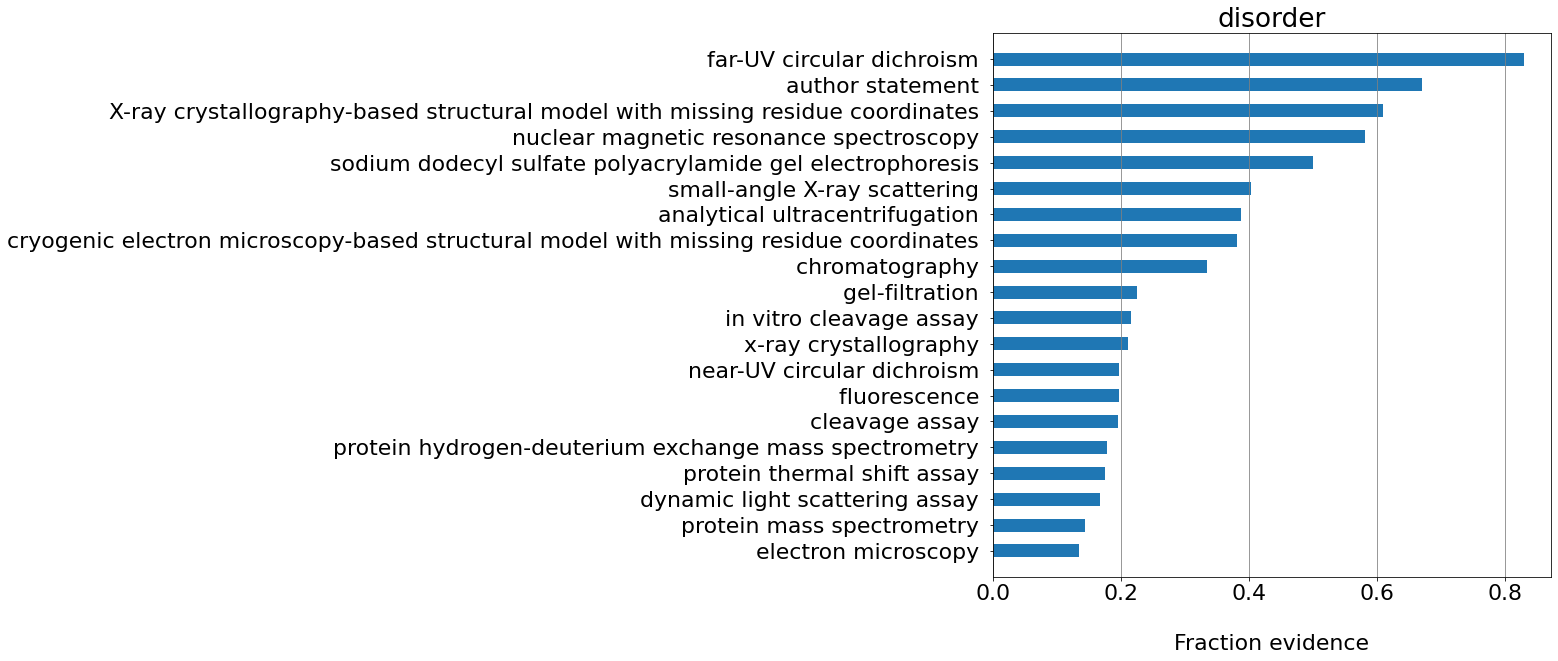

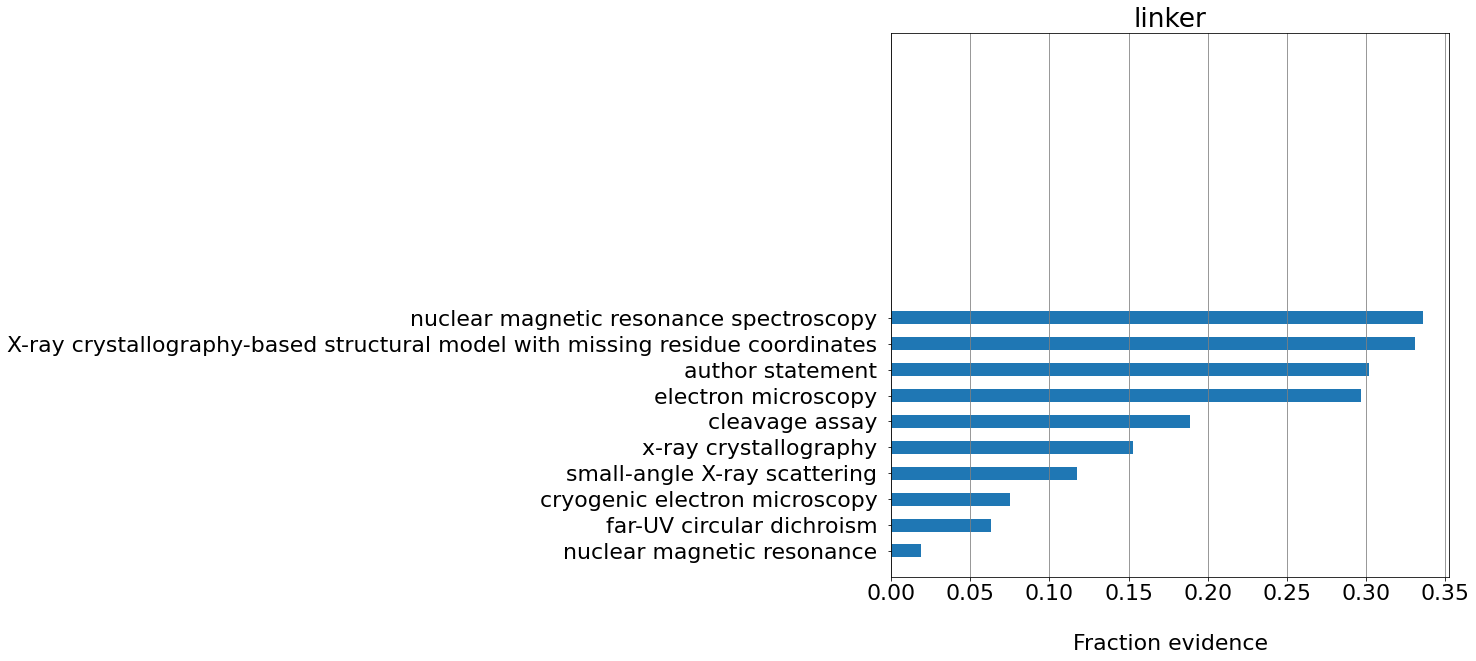

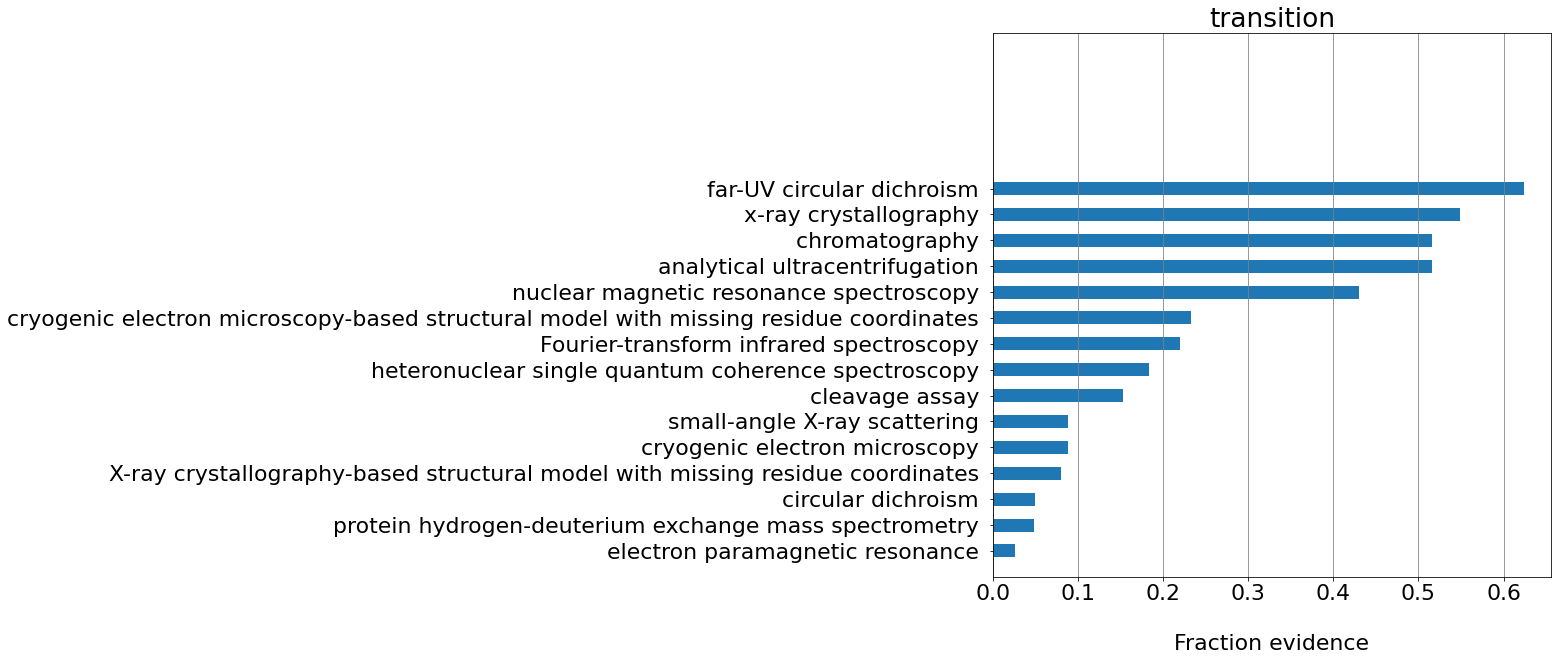

In [32]:
for challenge, df_g in df_ec.groupby('challenge'):
    fig, ax = plt.subplots(figsize=(10, 10))
    df_g['ec_name'] = df_g['ec_name'].map(lambda x: x.split('evidence')[0].split('used')[0])
    df_g.set_index('ec_name')['fraction'].iloc[-20:].plot(kind='barh', ax=ax)
    ax.xaxis.grid()
    ax.set_xlabel('Fraction evidence', labelpad=30)

    plt.title(challenge)
    fig.gca().set_ylabel("")
    ax.set_ybound(-1, 20)

    fig.gca().set_ylabel("")
    fig.savefig("{}/stat_ec_{}.png".format(fig_dir, challenge), dpi=300, bbox_inches='tight')
    # break

In [33]:
# ftp://ftp.ncbi.nih.gov/pub/taxonomy/new_taxdump
df_tax = pd.read_csv(ncbi_tax_file, sep="|", header=0, names=['id', '0', '1', '2', '3', '4', '5'], usecols=[0,3,4,5,6,7,9])
for i in df_tax.columns:
    if df_tax[i].dtype == 'object':
        df_tax[i] = df_tax[i].map(str.strip)
df_tax

,id,0,1,2,3,4,5
0,131567,,,,,,
1,2157,,,,,,
2,1935183,,,,,,Archaea
3,2798909,,,,,,Archaea
4,2798916,,,,,Candidatus Baldrarchaeota,Archaea
...,...,...,...,...,...,...,...
2470427,2413,,,,,,
2470428,2417,,,,,,
2470429,2414,,,,,,
2470430,2415,,,,,,


In [34]:
df_tax.loc[df_tax['id'] == 9606]

,id,0,1,2,3,4,5
813598,9606,Homo,Hominidae,Primates,Mammalia,Chordata,Eukaryota


In [35]:
df_ = pd.merge(df, df_tax, left_on='ncbi_taxon_id', right_on='id', how='left')
df_

,region_id,unpublished,ec_ontology,end,term_id,start,version,statement,term_name,ec_name,...,organism,sequence,challenge,id,0,1,2,3,4,5
0,DP02342r003,True,ECO,227,IDPO:00078,1,3,[{'text': 'CD spectra of Nm and Ng showed an i...,pre-molten globule,far-UV circular dichroism evidence used in man...,...,Mus musculus,MLCCMRRTKQVEKNDEDQKIEQDGVKPEDKAHKAATKIQASFRGHI...,disorder,10090,Mus,Muridae,Rodentia,Mammalia,Chordata,Eukaryota
1,DP02342r009,True,ECO,227,IDPO:00078,1,2,"[{'text': ""The NMR spectra of full-length Nm a...",pre-molten globule,nuclear magnetic resonance spectroscopy eviden...,...,Mus musculus,MLCCMRRTKQVEKNDEDQKIEQDGVKPEDKAHKAATKIQASFRGHI...,disorder,10090,Mus,Muridae,Rodentia,Mammalia,Chordata,Eukaryota
2,DP03000r002,True,ECO,456,IDPO:00078,1,3,[{'text': 'The experimentally observed values ...,pre-molten globule,chromatography evidence used in manual assertion,...,Nipah virus,MDKLELVNDGLNIIDFIQKNQKEIQKTYGRSSIQQPSIKDQTKAWE...,disorder,121791,Henipavirus,Paramyxoviridae,Mononegavirales,Monjiviricetes,Negarnaviricota,Viruses
3,DP03000r003,True,ECO,456,IDPO:00078,1,3,[{'text': 'The spectra are typical of proteins...,pre-molten globule,far-UV circular dichroism evidence used in man...,...,Nipah virus,MDKLELVNDGLNIIDFIQKNQKEIQKTYGRSSIQQPSIKDQTKAWE...,disorder,121791,Henipavirus,Paramyxoviridae,Mononegavirales,Monjiviricetes,Negarnaviricota,Viruses
4,DP03001r002,True,ECO,457,IDPO:00078,1,2,[{'text': 'The experimentally observed values ...,pre-molten globule,chromatography evidence used in manual assertion,...,Hendra virus (isolate Horse/Autralia/Hendra/1994),MDKLDLVNDGLDIIDFIQKNQKEIQKTYGRSSIQQPSTKDRTRAWE...,disorder,928303,Henipavirus,Paramyxoviridae,Mononegavirales,Monjiviricetes,Negarnaviricota,Viruses
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1102,DP03708r005,True,ECO,86,GO:0042803,41,0,[{'text': 'Interactions between 6xHis thioredo...,protein homodimerization activity,glutathione S-transferase pull-down assay evid...,...,Drosophila melanogaster,MEDLTKNIIFTNAINGQPATIQYQTADGTILKQPKIEGQKTEQQPT...,binding protein,7227,Drosophila,Drosophilidae,Diptera,Insecta,Arthropoda,Eukaryota
1103,DP03708r006,True,ECO,86,GO:0042803,1,0,[{'text': 'SAXS provides precise information a...,protein homodimerization activity,small-angle X-ray scattering evidence used in ...,...,Drosophila melanogaster,MEDLTKNIIFTNAINGQPATIQYQTADGTILKQPKIEGQKTEQQPT...,binding,7227,Drosophila,Drosophilidae,Diptera,Insecta,Arthropoda,Eukaryota
1104,DP03708r006,True,ECO,86,GO:0042803,1,0,[{'text': 'SAXS provides precise information a...,protein homodimerization activity,small-angle X-ray scattering evidence used in ...,...,Drosophila melanogaster,MEDLTKNIIFTNAINGQPATIQYQTADGTILKQPKIEGQKTEQQPT...,binding protein,7227,Drosophila,Drosophilidae,Diptera,Insecta,Arthropoda,Eukaryota
1105,DP03739r012,True,ECO,417,GO:0005516,390,0,"[{'text': 'However, on addition of Calmodulin,...",calmodulin binding,nuclear magnetic resonance spectroscopy eviden...,...,Homo sapiens,METTISEIHVENKDEKRSAEGSPGAERQKEKASMLCFKRRKKAAKA...,binding,9606,Homo,Hominidae,Primates,Mammalia,Chordata,Eukaryota


In [36]:
df_g = df_.loc[:, ['challenge', 'disprot_id', '5']].drop_duplicates().groupby(['challenge', '5']).count().sort_values(by=['challenge','5'])
df_g = df_g.reset_index().pivot(index='5', columns='challenge', values='disprot_id').loc[:, ['disorder', 'linker', 'binding']]
df_g

challenge,disorder,linker,binding
5,,,
Bacteria,43.0,3.0,11.0
Eukaryota,283.0,35.0,58.0
Viruses,22.0,2.0,10.0


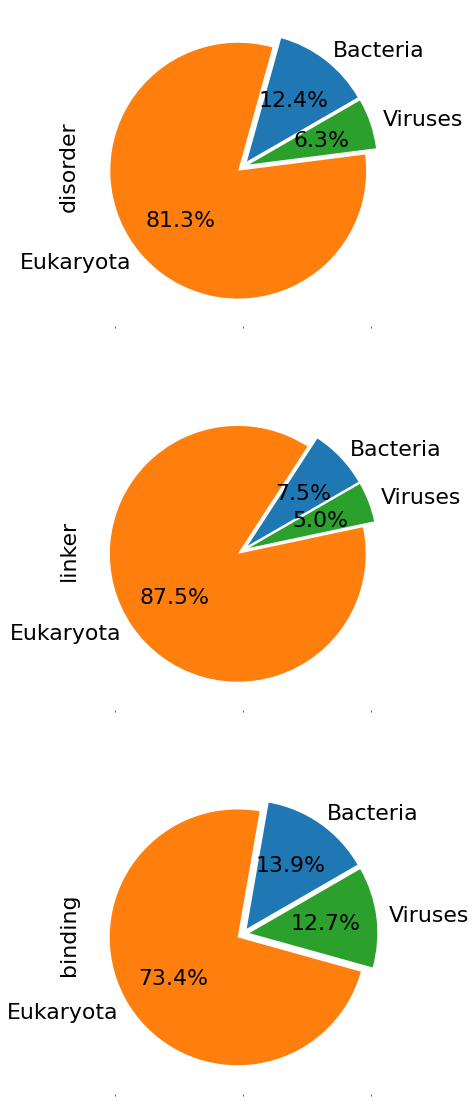

In [37]:
plot = df_g.plot.pie(subplots=True, figsize=(10, 20), explode=(0.05, 0.05, 0.05), legend=False, layout=(3,1), autopct='%1.1f%%', startangle=30)
plt.savefig("{}/stat_tax.png".format(fig_dir), dpi=300, bbox_inches='tight')

In [38]:
df = pd.read_csv(datase_file, sep="\t")
df

,disprot_id,acc,pos,aa,disorder,linker,transition,binding nucleic acid,binding,binding protein,disorder_nox,pdb
0,DP02342,P06837,1,M,1.0,NaN,NaN,NaN,NaN,NaN,1.0,NaN
1,DP02342,P06837,2,L,1.0,NaN,NaN,NaN,NaN,NaN,1.0,NaN
2,DP02342,P06837,3,C,1.0,NaN,NaN,NaN,NaN,NaN,1.0,NaN
3,DP02342,P06837,4,C,1.0,NaN,NaN,NaN,NaN,NaN,1.0,NaN
4,DP02342,P06837,5,M,1.0,NaN,NaN,NaN,NaN,NaN,1.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
287015,DP02544,Q04410,368,Q,1.0,NaN,NaN,NaN,NaN,NaN,1.0,NaN
287016,DP02544,Q04410,369,S,1.0,NaN,NaN,NaN,NaN,NaN,1.0,NaN
287017,DP02544,Q04410,370,S,1.0,NaN,NaN,NaN,NaN,NaN,1.0,NaN
287018,DP02544,Q04410,371,S,1.0,NaN,NaN,NaN,NaN,NaN,1.0,NaN


/home/damiano/miniconda3/lib/python3.9/site-packages/matplotlib_venn/_venn3.py:117: UserWarning: Bad circle positioning
  warnings.warn("Bad circle positioning")


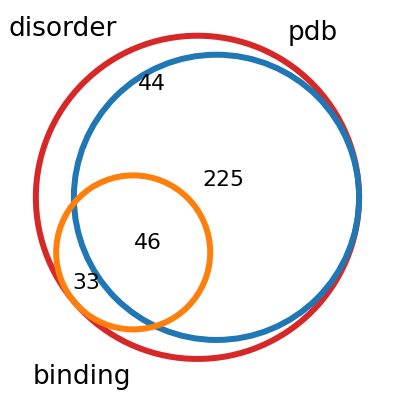

In [39]:
from matplotlib_venn import venn3, venn3_circles

colors = ['#D72828', '#2077B5', '#FF7F0D']
labels = ['disorder', 'pdb', 'binding']
sets = [set(df.loc[df[label].notnull(), 'disprot_id']) for label in labels]

plt.figure(figsize=(7, 7))
v = venn3(subsets=sets, set_labels=labels, alpha=.0)

for text, i in zip(v.set_labels, [(1, 1), (1, 1.1), (1.8, 1.2)]):
    x, y = text.get_position()
    # print(text, x, y)
    text.set_position((x * i[0], y * i[1]))

circles = venn3_circles(subsets=sets)
for color, circle in zip(colors, circles):
    circle.set_edgecolor(color)
    circle.set_linewidth(6)

plt.savefig("{}/stat_venn.png".format(fig_dir), dpi=300, bbox_inches='tight')

In [40]:
# TODO
# statistics of fully disordered proteins